<a href="https://colab.research.google.com/github/effepivi/gvxr-demos/blob/main/12-move-detector/12-move-detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check if the notebook is running in Google Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q ipympl

    from google.colab import output
    output.enable_custom_widget_manager()

    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -q --force-reinstall "/content/drive/MyDrive/Colab Notebooks/gvxr-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl"
else:
    !pip install -q gvxr

The working directory is not necessary the path of the Notebook on my Mac. The line below enables us to locate the path of the notebbok. This is useful to save output files. 

In [2]:
current_folder = str(globals()['_dh'][0])

Import Python packages. Nothing too fancy here.

In [3]:
%matplotlib widget

from IPython.display import Image

import math, os
import numpy as np
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Create the output directory if it does not exists.

In [4]:
if not os.path.exists(current_folder + "/img"):
    os.mkdir(current_folder + "/img")

Import gVXR and create an OpenGL context. The code below works on Google Colab, GNU/Linux computers, Windows, and MacOS (only the Intel architecture was tested).

In [5]:
from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
gvxr.useLogFile()

# Create an OpenGL context
# MS Windows
if os.name == "nt":
    print("Creating an OpenGL context using EGL is not possible on Microsoft Windows")
    print("A window will be created but not displayed")
    gvxr.createWindow(0, True, "OPENGL");
# MacOS
elif str(os.uname()).find("Darwin") >= 0:
    print("Creating an OpenGL context using EGL is not possible on MacOS")
    print("A window will be created but not displayed")
    gvxr.createWindow(0, True, "OPENGL");
# GNU/Linux
else:
    print("Create an OpenGL context using EGL")
    gvxr.createWindow(0, 1, "EGL");

Mon Oct 30 09:31:58 2023 (WW) Spekpy is not installed, try Xpecgen instead.
Mon Oct 30 09:31:58 2023 (WW) Xpecgen is not installed either.


SimpleGVXR 2.0.7 (2023-10-30T09:00:57) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.7 (2023-10-30T09:00:56) [Compiler: GNU g++] on Linux
Create an OpenGL context using EGL


Define a function to print some of the simulation states.

In [6]:
def printDetector():
    print("Detector position:", gvxr.getDetectorPosition("cm"), "cm")
    print("Detector up vector:", gvxr.getDetectorUpVector())
    print("Detector right vector:", gvxr.getDetectorRightVector())
    print("Detector size:", gvxr.getDetectorSize("cm"), "cm")
    print("Detector number of pixels:", gvxr.getDetectorNumberOfPixels())
    # print("Detector pixel spacing:", gvxr.getDetectorNumberOfPixels())

Locate the sample STL file from the package directory. This way we know the notebook will run on any platform.

In [7]:
path = os.path.dirname(gvxr.__file__)
fname = path + "/welsh-dragon-small.stl"

gvxr.loadMeshFile("Dragon", fname, "mm")

gvxr.moveToCentre("Dragon");
# gvxr.applyCurrentLocalTransformation("Dragon");

gvxr.setElement("Dragon", "C")
gvxr.setColour("Dragon", 0.5, 0.7, 0, 1)

Set the detector default properties.

In [8]:
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm");
gvxr.setDetectorUpVector(0, 0, -1);
gvxr.setDetectorNumberOfPixels(640, 320);
gvxr.setDetectorPixelSize(0.5, 0.5, "mm");
gvxr.setScintillator("CsI", 600, "um");

Set the source default properties. If Spekpy and Xpecgen are not enabled, a monochromatic source is used. 
If Spekpy or Xpecgen is enabled, a 150 kV tube voltage with a filtration of 10 mm of aluminium and 5 mm of copper are used. 
I resampled the spectrum to make sure I had enough graphics memroy with the integrated GPU on my old Macbbok Pro.

In [9]:
gvxr.usePointSource();
gvxr.setSourcePosition(-40.0,  0.0, 0.0, "cm");

if gvxr.hasSpekpy() or gvxr.hasXpecgen():
    gvxr.setVoltage(150, "kV")
    gvxr.addFilter("Al", 10, "mm");
    gvxr.addFilter("Cu", 5, "mm");
    filtered_bins = gvxr.getEnergyBins("keV");
    filtered_counts= np.array(gvxr.getPhotonCountEnergyBins());

    x = filtered_bins
    y = filtered_counts
    nb_channels = 15
    f = signal.resample(y, nb_channels - 1)
    xnew = np.linspace(x[0], x[-1], nb_channels - 1, endpoint=False)

    f = np.append(f, y[-1])
    xnew = np.append(xnew, x[-1])

    gvxr.resetBeamSpectrum();

    for energy, count in zip(xnew, f):
        gvxr.addEnergyBinToSpectrum(energy,
                                    "keV",
                                    count);
else:
    gvxr.setMonoChromatic(150, "keV", 8000)

gvxr.setNumberOfPhotons(8000)

If Spekpy or Xpecgen is enabled, plot the spectrum.

In [10]:
if gvxr.hasSpekpy() or gvxr.hasXpecgen():
    bins = gvxr.getEnergyBins("keV");
    counts= np.array(gvxr.getPhotonCountEnergyBins());

    fig = plt.figure()
    plt.title("Beam spectrum\nTube voltage: 150 kV, filtration: 10 mm of Al and 5 mm of Cu")

    plt.bar(filtered_bins, filtered_counts)
    plt.plot(xnew, f, color="black")

    plt.xlabel("Energy (in keV)")
    plt.ylabel("Photon count (in arbitrary unit)")

    plt.savefig(current_folder + "/img/spectrum.png", bbox_inches='tight', pad_inches=0)

    plt.show()

Save the direction of the right vector and print the current state.

In [11]:
right_vector = gvxr.getDetectorRightVector()
printDetector()

Detector position: (10.0, 0.0, 0.0) cm
Detector up vector: (0.0, 0.0, -1.0)
Detector right vector: (-0.0, 1.0, 0.0)
Detector size: (32.0, 16.0) cm
Detector number of pixels: (640, 320)


Use a focal spot size of 1.5 $\times$ 0.5 mm<sup>2</sup> rotated by 25&deg;.

In [12]:
gvxr.setFocalSpotAsRectangle(-40.0, 0, 0.0,
    1.5, 0.5, # Size along the 2D axes
    "cm",
    5, 3); # Number of point sources along each axis

gvxr.rotateSource(25, 0, 0, 1);

Simulate the corresponding X-ray image. By default the detector is perpendicular to i) the vector from the centre of the source to the centre of the detector, and ii) the up-vector of the detector. In practice the right vector of the detector is computed with a cross-product between these two vectors.

In [13]:
x_ray_image_1 = np.array(gvxr.computeXRayImage()).astype(np.single)
gvxr.displayScene()

Set the parameters of the 3D visualisation window to illustrate how the orientation of the detector can be altered.

In [14]:
gvxr.setZoom(1000)

angle = 0.0#math.pi / 2.0
rotation_matrix_x = np.array([ 1, 0, 0, 0,
                               0, math.cos(angle), -math.sin(angle), 0,
                               0, math.sin(angle),  math.cos(angle), 0,
                               0, 0, 0, 1])

rotation_matrix_z = np.array([ math.cos(angle), -math.sin(angle), 0, 0,
                               math.sin(angle),  math.cos(angle), 0, 0,
                               0, 0, 1, 0,
                               0, 0, 0, 1])

rotation_matrix_x.shape = [4,4]
rotation_matrix_z.shape = [4,4]

transformation_matrix = np.identity(4)

transformation_matrix = np.matmul(rotation_matrix_x, transformation_matrix)
transformation_matrix = np.matmul(rotation_matrix_z, transformation_matrix)

gvxr.setSceneRotationMatrix(transformation_matrix.flatten())

gvxr.setWindowBackGroundColour(1, 1, 1)

gvxr.displayScene()

Grab a screenshot of the 3D visualisation window.

In [15]:
gvxr.displayScene()
screenshot1 = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

Overwrite the detector's right vector. In this case the perpendicularity described above is lost. Simulate the corresponding X-ray image and take a screenshot.

In [16]:
gvxr.setDetectorRightVector(1, 1, 0)
printDetector()
x_ray_image_2 = np.array(gvxr.computeXRayImage()).astype(np.single)
gvxr.displayScene()
screenshot2 = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

Detector position: (10.0, 0.0, 0.0) cm
Detector up vector: (0.0, 0.0, -1.0)
Detector right vector: (0.7071067690849304, 0.7071067690849304, 0.0)
Detector size: (32.0, 16.0) cm
Detector number of pixels: (640, 320)


Compare the two sets of images.

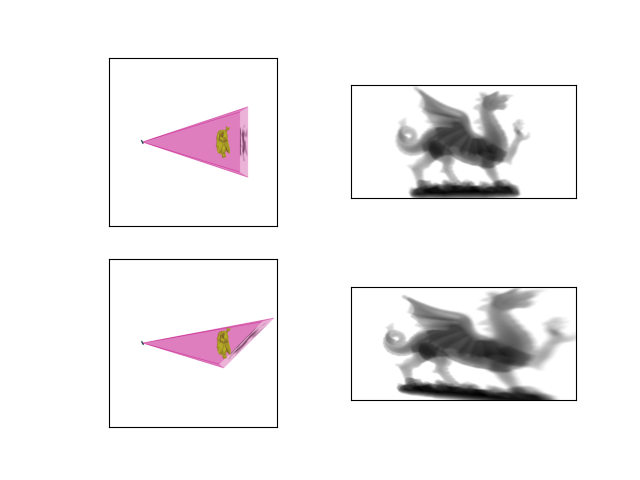

In [17]:
fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(screenshot1)
axs[0,1].imshow(x_ray_image_1, cmap="gray")

axs[1,0].imshow(screenshot2)
axs[1,1].imshow(x_ray_image_2, cmap="gray")


for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(current_folder + "/img/not_perpendicular.png", bbox_inches='tight', pad_inches=0)
plt.show()

Realign the detector. Either use:
```python
gvxr.autoAlignDetector(True);
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm");
gvxr.autoAlignDetector(False);
```
In this case the automatic behaviour is used so that the detector is perpendicular to i) the vector from the centre of the source to the centre of the detector, and ii) the up-vector of the detector. Or used
```python
gvxr.setDetectorRightVector(right_vector[0], right_vector[1], right_vector[2]);
```
because we saved the initial state of the right vector in the `right_vector` variable.

In [18]:
gvxr.autoAlignDetector(True);
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm");
gvxr.autoAlignDetector(False);
# gvxr.setDetectorRightVector(right_vector[0], right_vector[1], right_vector[2]);
gvxr.computeXRayImage();
gvxr.displayScene();

Create an animation where the position of the focal spot follows a sine wave.

In [19]:
fig, anim_axs = plt.subplots(1, 2)

img1 = anim_axs[0].imshow(screenshot1)
img2 = anim_axs[1].imshow(x_ray_image_1, cmap="gray")

for ax in anim_axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

x = np.linspace(-math.pi, math.pi, 30)

def animate(i):
    gvxr.setFocalSpotAsRectangle(-40.0, 1.5 * math.sin(i), 0.0,
        1.5, 0.5, # Size along the 2D axes
        "cm",
        5, 3); # Number of point sources along each axis

    gvxr.rotateSource(25, 0, 0, 1);

    xray = np.array(gvxr.computeXRayImage(), dtype=np.single)
    gvxr.displayScene()
    screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

    img1.set_data(screenshot)
    img2.set_data(xray)
    return


ani = animation.FuncAnimation(fig, animate, repeat=False, frames=len(x))

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save(current_folder + '/img/anim-motion-source.gif', writer=writer)

plt.close()

Play the animation

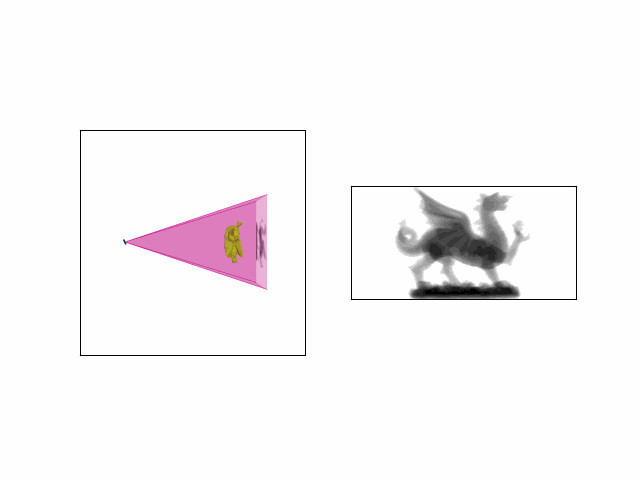

In [20]:
display(Image(data=open(current_folder + '/img/anim-motion-source.gif','rb').read(), format='png'))

Reset the simulation state

In [21]:
gvxr.setFocalSpotAsRectangle(-40.0, 0.0, 0.0,
    1.5, 0.5, # Size along the 2D axes
    "cm",
    5, 3); # Number of point sources along each axis

gvxr.rotateSource(25, 0, 0, 1);

gvxr.computeXRayImage();
gvxr.displayScene();

Create an animation where the position of the detector follows a sine wave.

In [22]:
fig, anim_axs = plt.subplots(1, 2)

img1 = anim_axs[0].imshow(screenshot1)
img2 = anim_axs[1].imshow(x_ray_image_1, cmap="gray")

for ax in anim_axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

x = np.linspace(-math.pi, math.pi, 30)

def animate(i):
    gvxr.setDetectorPosition(10.0, 1.5 * math.sin(i), 0.0, "cm");

    xray = np.array(gvxr.computeXRayImage(), dtype=np.single)
    gvxr.displayScene()
    screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

    img1.set_data(screenshot)
    img2.set_data(xray)
    return


ani = animation.FuncAnimation(fig, animate, repeat=False, frames=len(x))

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save(current_folder + '/img/anim-motion-detector.gif', writer=writer)

plt.close()

Play the animation

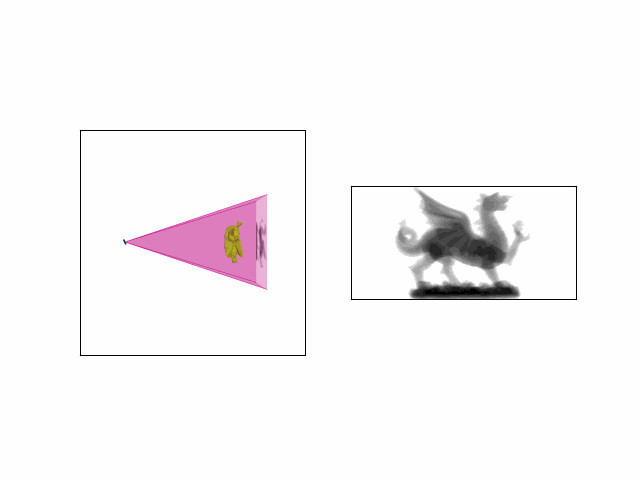

In [23]:
display(Image(data=open(current_folder + '/img/anim-motion-detector.gif','rb').read(), format='png'))

Reset the simulation state

In [24]:
gvxr.autoAlignDetector(True);
gvxr.setFocalSpotAsRectangle(-40.0, 0.0, 0.0,
    1.5, 0.5, # Size along the 2D axes
    "cm",
    5, 3); # Number of point sources along each axis

gvxr.rotateSource(25, 0, 0, 1);
gvxr.setDetectorPosition(10.0, 0.0, 0.0, "cm");
gvxr.autoAlignDetector(False);

gvxr.computeXRayImage();
gvxr.displayScene();

Define a function to simulate motion blur, e.g. when the detector moves during the acquisition of an image.

In [25]:
def motion(number_of_frames, start_pos, end_pos):
    gvxr.enablePoissonNoise()
    number_of_photons_bak = gvxr.getNumberOfPhotons()
    gvxr.setNumberOfPhotons(number_of_photons_bak // number_of_frames)

    screenshot = np.zeros(screenshot1.shape, dtype=np.single)
    x_ray_image = np.zeros(x_ray_image_1.shape, dtype=np.single)

    positions = np.linspace(start_pos, end_pos, number_of_frames)

    for pos in positions:
        gvxr.setDetectorPosition(pos[0], pos[1], pos[2], "cm");
        x_ray_image += gvxr.computeXRayImage();
        gvxr.displayScene()
        screenshot += gvxr.takeScreenshot();

    gvxr.setNumberOfPhotons(number_of_photons_bak)

    screenshot = (255 * screenshot / number_of_frames).astype(np.uint8)

    fig, axs = plt.subplots(1, 2)
    plt.suptitle("Motion blur using " + str(number_of_frames) + " frames")
    img1 = axs[0].imshow(screenshot)
    img2 = axs[1].imshow(x_ray_image, cmap="gray")

    for ax in anim_axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(current_folder + "/img/motion_blur-" + str(number_of_frames) + "frames.png", bbox_inches='tight', pad_inches=0)
    plt.show()

    return screenshot, x_ray_image

Simulate the motion blur with a total number of 8000 (Poisson noise may be visible). We simulate 5 images where the time is sampled with 1, 2, 3, 5, and 10 steps respectively. If a low nomber of steps are used to sample of the time, then temporal aliasing may be observed. This is particularly the case with 2, 3, and 5 steps.

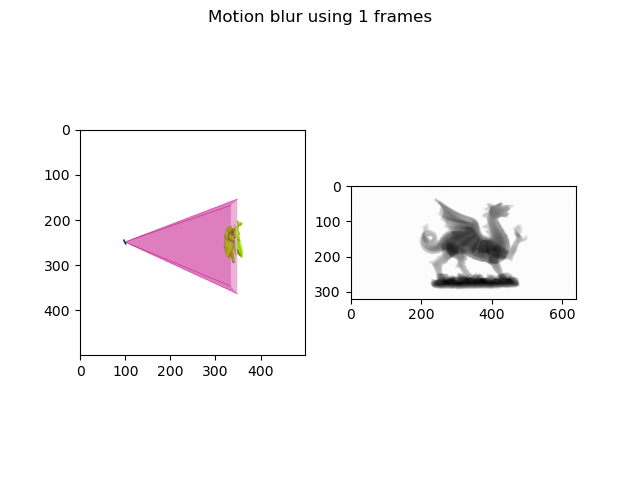

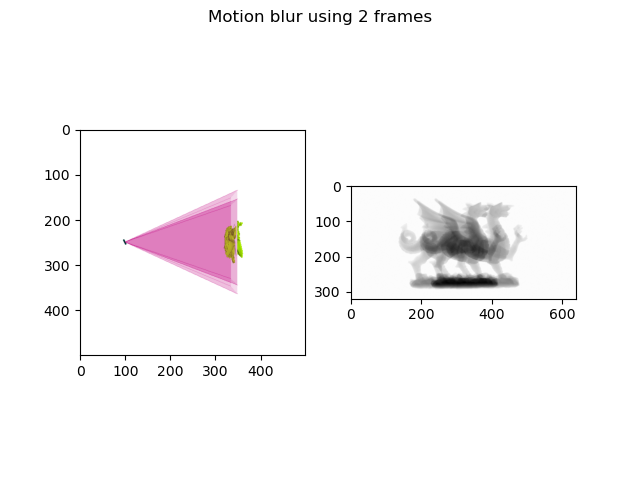

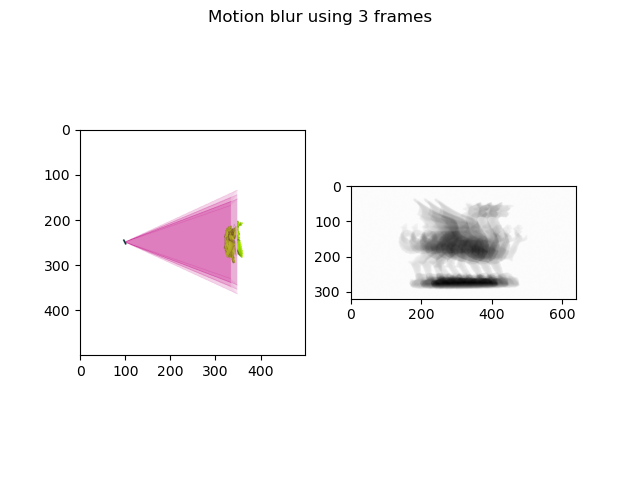

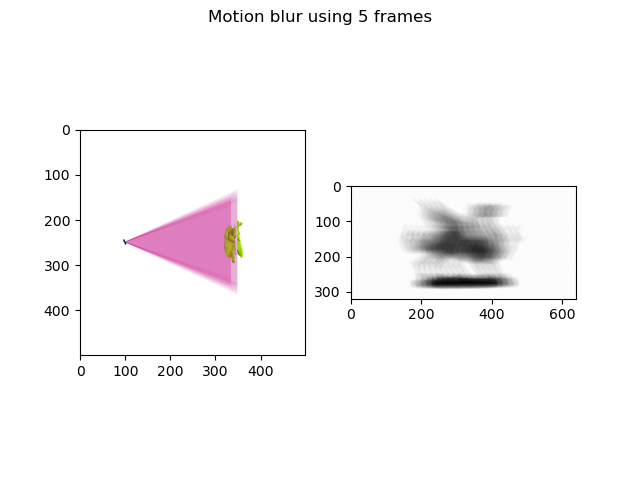

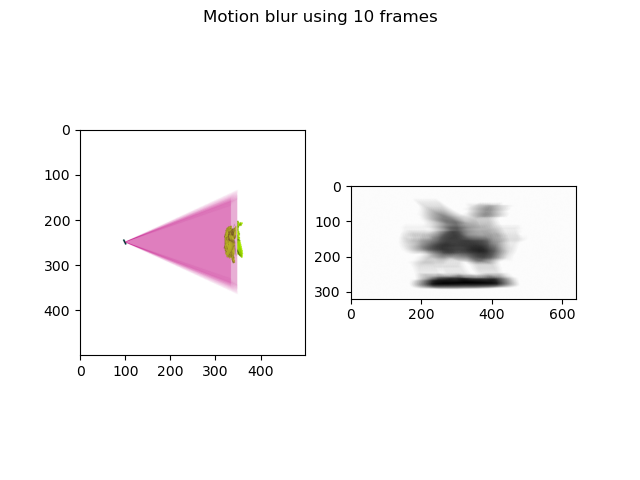

In [26]:
gvxr.setNumberOfPhotons(8000);

start_position = [0, -1.5, 0]
end_position = [0, 1.5, 0]

screenshot, x_ray_image = motion(1,  start_position, end_position)
screenshot, x_ray_image = motion(2,  start_position, end_position)
screenshot, x_ray_image = motion(3,  start_position, end_position)
screenshot, x_ray_image = motion(5,  start_position, end_position)
screenshot, x_ray_image = motion(10, start_position, end_position)

In [27]:
gvxr.destroyAllWindows()
gvxr.terminate()